In [81]:
import jupyterlab_dash
import dash
import dash_html_components as html
import pandas as pd
import numpy as np
from dash.dependencies import Input, Output,State
import dash_core_components as dcc


import pickle
import torch
import torchvision.transforms as transforms
import torch
from torchvision.transforms import Resize, ToTensor, Normalize
import torch.nn as nn

from PIL import Image


viewer = jupyterlab_dash.AppViewer()

In [67]:
containerStyle = {'box-shadow': '2px 2px 2px lightgrey','padding': '15px','background-color': '#f9f9f9'}

bottomMargin = '1.0em'

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']



app = dash.Dash(__name__, external_stylesheets=external_stylesheets,
               assets_folder='/Users/roshansk/Documents/Projects/CovidImaging/assets',
               assets_url_path='/')

app.layout = html.Div(children=[
    html.H1(children='DL Net Visualizer'),
    
    html.Div(dcc.Store(id="activationData")),
    
    html.Div([
        
        html.Div([
            html.H5("side bar"),
            html.Label('Model Folder'),
            dcc.Input(value='', type='text', id='modelFolderInput', style = {'marginBottom': bottomMargin}),
            
            html.Label('Image Folder'),
            dcc.Input(value='', type='text', id = 'imageFolderInput', style = {'marginBottom': bottomMargin}),
                        
            html.Button('Initialize', id='initButton', n_clicks=0, style = {'marginBottom': bottomMargin}),

            html.Label('Model'),
            dcc.Dropdown(id = 'modelInput',value='', style = {'marginBottom': bottomMargin}),
            
            html.Label('Image'),
            dcc.Dropdown(id = 'imageInput',value='', style = {'marginBottom': bottomMargin}),
          
            html.Button('Load', id='loadButton', n_clicks=0, style = {'marginBottom': bottomMargin}),
            
            html.Label('Layer'),
            dcc.Dropdown(id = 'layerInput',value='', style = {'marginBottom': bottomMargin})
            
            
            
            
        ],className='three columns container', style = containerStyle),
        
        html.Div([
            html.H5('main bar')
        ], className = 'nine columns container-display' )
        
        
    ]),
    
    html.Img(id='image', src = 'arr.jpg')
    
    
    

   
])


@app.callback(
    [Output(component_id='modelInput', component_property='options'),
     Output(component_id='imageInput', component_property='options')],
    [Input(component_id='initButton', component_property='n_clicks')],
     [State(component_id='modelFolderInput', component_property='value'),
     State(component_id='imageFolderInput', component_property='value')]
)
def update_model_options(nClicks, modelFolderInput, imageFolderInput):
    
    
    if modelFolderInput == '':
        modelOptions = []
    else:
        fileList = os.listdir(modelFolderInput)

        modelOptions = []

        for i in fileList:
            if ".pt" in i:
                modelOptions.append({'label':i, 'value':i})
    
    if imageFolderInput =='':
        imgOptions = []
    else:
        fileList = os.listdir(imageFolderInput)

        imgOptions = []

        for i in fileList:
            if '.jpg' in i or '.png' in i or 'jpeg' in i:
                imgOptions.append({'label':i, 'value':i})
    
    
    return modelOptions, imgOptions


@app.callback(
    Output('testText','children'),
    [Input('loadButton','n_clicks')])
def updateText(nClicks):
    return "No of clicks " + str(nClicks)



@app.callback(
     Output(component_id='layerInput', component_property = 'options'),
    [Input(component_id='loadButton', component_property='n_clicks')],
    [State(component_id='modelInput', component_property='value'),
     State(component_id='imageInput', component_property='value'),
     State(component_id='modelFolderInput', component_property='value'),
     State(component_id='imageFolderInput', component_property='value')]
)
def update_activations(nClicks, model, image, modelFolder, imageFolder):
    
    if nClicks == 0:
        return {'a':1,'b':2}
    
    if modelFolder=='':
        return {'c':1,'d':2}
    
    print(model,image, modelFolder, imageFolder)
    print("HERE!!!")
    
    net = torch.load(os.path.join(modelFolder, model), map_location=torch.device('cpu'))
    
    img =  Image.open(os.path.join(imageFolder, image)).convert('RGB')

    
    imgSize = 256
    trainTransforms = transforms.Compose([Resize( (imgSize, imgSize) ), ToTensor(),
                                          Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) ])
    img1 = trainTransforms(img)
    
    print("Here")
    
    x = img1.unsqueeze(0)
    
    activations = {}
    
    ## Extracting activations
    for name, module in net.named_children():
    
        if 'layer' in name:        
            for name_,layer in module.named_children():
                x = layer(x)
                activations[name+"_"+name_] = x.detach().cpu().numpy()

        else:
            x = module(x)
            activations[name] = x.detach().cpu().numpy()

            if 'avgpool' ==name:
                x= x.view(x.size(0),-1)
                
                
    outFile = os.path.join(os.getcwd(),'assets')
    pickleFile = open( os.path.join(outFile,"activationData.pkl" ), "wb")
    pickle.dump(a, pickleFile)
    pickleFile.close()
                
    
    
    layerOptions = []
    
    for key in list(activations.keys()):
        layerOptions.append({'value':key,'label':key})

    return  layerOptions



@app.callback(
Output('image','src'),
[Input('layerInput','value')])
def displayFigure(layerInput):
    
    pickleFile = os.path.join(os.getcwd(),'assets','activationData.pkl')
    activationData = pickle.load( open( pickleFile, "rb" ) )
    
    act = activationData[layerInput].squeeze(0)
    
    plt.figure(figsize = (15,15))

    for i in range(6):
        for j in range(6):
            plt.subplot(6,6,i*6 + j + 1)
            plt.imshow(act[i*6 + j, : , :], cmap='gray')
    
    filename = os.path.join(os.getcwd(),'assets', 'arr.jpg')
    plt.savefig(filename)
    
    return 'arr.jpg'


# @app.callback(
#     Output('image','src'),
#     [Input('layerInput','value')],
#     [State('activationData','data')]
# )
# def updateFig(layerInput, activationData):
    
#     print(layerInput)
    
#     act = activationData[layerInput].squeeze(0)
    


#     plt.figure(figsize = (15,15))

#     for i in range(6):
#         for j in range(6):
#             plt.subplot(6,6,i*6 + j + 1)
#             plt.imshow(act[i*6 + j, : , :], cmap='gray')
    
#     folder = os.path.join(os.getcwd(),'assets')
#     plt.savefig(os.path.join(folder,'arr.jpg'))
    
#     return 'arr.jpg'
    
    
    




viewer.show(app)

In [ ]:
viewer.show(app)

In [31]:
/Users/roshansk/Documents/Projects/CovidImaging/Visualization

In [7]:
/Users/roshansk/Documents/Projects/CovidImaging/Visualization/Images

In [ ]:
/Users/roshansk/Documents/CBIG/RaceDL_BACKUP/Modeling/PyTorch/Models/activations.png

In [56]:
app.get_asset_url('arr.jpg')

'//arr.jpg'

In [28]:
!which python

/Users/roshansk/opt/anaconda3/bin/python


In [111]:
a = {'sdfs':1,'dsfdg':2}

In [116]:
app.get_asset_url('1')

'//1'

In [113]:
app

TypeError: file must have a 'write' attribute

In [117]:
help(dash.Dash)

Help on class Dash in module dash.dash:

class Dash(builtins.object)
 |  Dash(name=None, server=True, assets_folder='assets', assets_url_path='assets', assets_ignore='', assets_external_path=None, eager_loading=False, include_assets_files=True, url_base_pathname=None, requests_pathname_prefix=None, routes_pathname_prefix=None, serve_locally=True, compress=True, meta_tags=None, index_string='<!DOCTYPE html>\n<html>\n    <head>\n        {%metas%}\n        <title>{%title%}</title>\n        {%favicon%}\n        {%css%}\n    </head>\n    <body>\n        {%app_entry%}\n        <footer>\n            {%config%}\n            {%scripts%}\n            {%renderer%}\n        </footer>\n    </body>\n</html>', external_scripts=None, external_stylesheets=None, suppress_callback_exceptions=None, show_undo_redo=False, plugins=None, **obsolete)
 |  
 |  Dash is a framework for building analytical web applications.
 |  No JavaScript required.
 |  
 |  If a parameter can be set by an environment variable, 

In [119]:
pickleFile = os.path.join(os.getcwd(),'assets','activationData.pkl')
activationData = pickle.load( open( pickleFile, "rb" ) )

In [121]:
activationData.keys()

dict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1_0', 'layer1_1', 'layer1_2', 'layer2_0', 'layer2_1', 'layer2_2', 'layer2_3', 'layer3_0', 'layer3_1', 'layer3_2', 'layer3_3', 'layer3_4', 'layer3_5', 'layer4_0', 'layer4_1', 'layer4_2', 'avgpool', 'fc'])

In [122]:
activationData['layer4_0'].shape

(1, 2048, 8, 8)

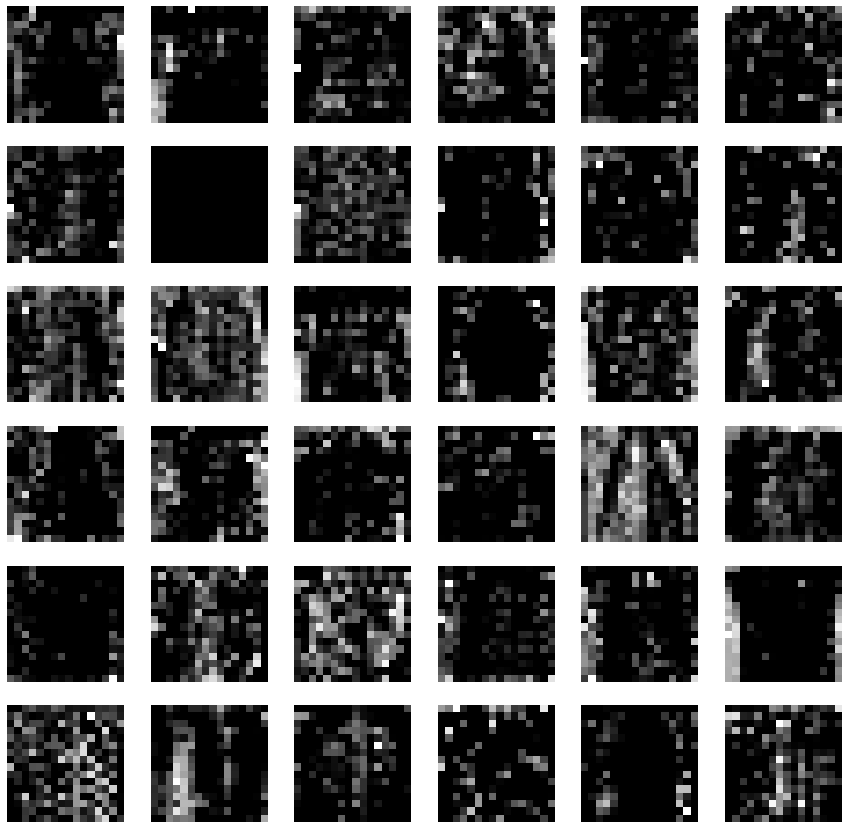

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (15,15))

act = activationData['layer3_0'].squeeze(0)

for i in range(6):
    for j in range(6):
        plt.subplot(6,6,i*6 + j + 1)
        plt.imshow(act[i*6 + j, : , :], cmap='gray')
        plt.axis('off')
        

        
plt.savefig(os.path.join(os.getcwd(),'assets', 'arr2.jpg'), bbox_inches='tight', pad_inches = 0)





In [129]:
plt.close()

In [132]:
help(matplotlib.pyplot.switch_backend)

Help on function switch_backend in module matplotlib.pyplot:

switch_backend(newbackend)
    Close all open figures and set the Matplotlib backend.
    
    The argument is case-insensitive.  Switching to an interactive backend is
    possible only if no event loop for another interactive backend has started.
    Switching to and from non-interactive backends is always possible.
    
    Parameters
    ----------
    newbackend : str
        The name of the backend to use.



In [131]:
import matplotlib

In [135]:
os.path.exists( os.path.join(os.getcwd(),'assets','arr5.jpg'))

False

In [136]:
help(plt.savefig)

Help on function savefig in module matplotlib.pyplot:

savefig(*args, **kwargs)
    Save the current figure.
    
    Call signature::
    
      savefig(fname, dpi=None, facecolor='w', edgecolor='w',
              orientation='portrait', papertype=None, format=None,
              transparent=False, bbox_inches=None, pad_inches=0.1,
              frameon=None, metadata=None)
    
    The output formats available depend on the backend being used.
    
    Parameters
    ----------
    
    fname : str or PathLike or file-like object
        A path, or a Python file-like object, or
        possibly some backend-dependent object such as
        `matplotlib.backends.backend_pdf.PdfPages`.
    
        If *format* is not set, then the output format is inferred from
        the extension of *fname*, if any, and from :rc:`savefig.format`
        otherwise.  If *format* is set, it determines the output format.
    
        Hence, if *fname* is not a path or has no extension, remember to
      